# April 2, 2022: Schaefer parcellation (300), hemodynamic lag 2

In [22]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

## emoprox2 full dataset

In [23]:
def get_data_samples(data, subject_list):
    X = [] 
    y = []
    Xlen = [] 
    pos = [] 
    idx = []

    for subject in subject_list:
        X += data[subject][0]
        y += data[subject][1]
        Xlen += [i.shape[0] for i in data[subject][0]]
        pos += data[subject][2]
        idx += data[subject][3]

    X_padded = tf.keras.preprocessing.sequence.pad_sequences(
        X, padding="post",
        dtype='float'
    )

    y_padded = tf.keras.preprocessing.sequence.pad_sequences(
        y, padding="post",
        dtype='float'
    )

    return X_padded, y_padded, Xlen, pos, idx

In [24]:
hemo_lag = 2
raw_data_file = (f"/home/joyneelm/approach-retreat/near_miss_analysis/classification_data"
                 f"/Schaefer2018_roi300_net17_122subjs_full_segments_withshock_hemodynamic_lag{hemo_lag}.pkl")
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

In [25]:
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

In [26]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[args.num_train:]

(X_train, y_train, 
 len_train, 
 pos_train, idx_train) = get_data_samples(data, train_list)
(X_test, y_test, 
 len_test, 
 pos_test, idx_test) = get_data_samples(data, test_list)

## model

### training

In [27]:
# model
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 100
args.validation_split = 0.2
args.batch_size = 64

# multiplier to adversarial regularization loss. Defaults to 0.2. 
args.adv_multiplier = 1
# step size to find the adversarial sample. Defaults to 0.001. 
args.adv_step_size = 3
# type of tensor norm to normalize the gradient. Defaults to L2 norm. 
# Input will be converted to NormType when applicable 
# (e.g., a value of 'l2' will be converted to nsl.configs.NormType.L2). 
args.adv_grad_norm = 'l2'

args.temp = 20

In [28]:
regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

In [29]:
tf.random.set_seed(args.SEED)

regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

model_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}"
history_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_hemolag{hemo_lag}_history"
if os.path.exists(model_file):
    # load the model
    model = tf.keras.models.load_model(model_file)
    history = json.load(open(f"{history_file}", 'r'))
else:
    # build, train, and save the model
    '''
    build model
    '''
    model = get_GRU_classifier_model(
        X_train, 
        args, 
        regularizer)

    '''
    train model
    '''
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    then = time.time()
    history = model.fit(
        x=X_train, 
        y=y_train,
        batch_size=args.batch_size, 
        epochs=args.num_epochs, 
        verbose=1,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
        validation_split=args.validation_split, 
        shuffle=True)
    print('--- train time =  %0.4f seconds ---' %(time.time() - then))

    '''
    save model
    '''
    model.save(model_file)
    history = history.history
    json.dump(history, open(f"{history_file}", 'w'))
    
# evaluate the model
eval_hist = model.evaluate(X_test, y_test)

70/70 [==============================] - 3s 45ms/step - loss: nan - sparse_categorical_accuracy: 0.7086


### null models

In [30]:
num_null_models = 100
null_eval_hists_file = f"{results_dir}/emoprox_full_data/models/GRU_classifier_null_eval_hists_hemolag{hemo_lag}"
if not os.path.exists(null_eval_hists_file):
    null_eval_hists = []
    for idx_null in tqdm(np.arange(num_null_models)):
        # build, train, and save the model
        '''
        build model
        '''
        null_model = get_GRU_classifier_model(
            X_train, 
            args, 
            regularizer)

        '''
        train model
        '''
        null_model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=optimizer,
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        then = time.time()
        null_history = null_model.fit(
            x=X_train, 
            y=np.random.randint(low=0, high=2, size=(y_train.shape)).astype(float),
            batch_size=args.batch_size, 
            epochs=args.num_epochs, 
            verbose=1,
            callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
            validation_split=args.validation_split, 
            shuffle=True)
        print('--- train time =  %0.4f seconds ---' %(time.time() - then))

        # evaluate the model
        null_eval_hists.append(null_model.evaluate(X_test, y_test, verbose=0)[1])
    
    # save null evaluations
    with open(null_eval_hists_file, 'wb') as f:
        pickle.dump(null_eval_hists, f)
else:
    # load null evaluations
    with open(null_eval_hists_file, 'rb') as f:
        null_eval_hists = pickle.load(f) 

Text(0.5, 1.0, 'accuracy histograms of null models (blue) and actual model (red)')

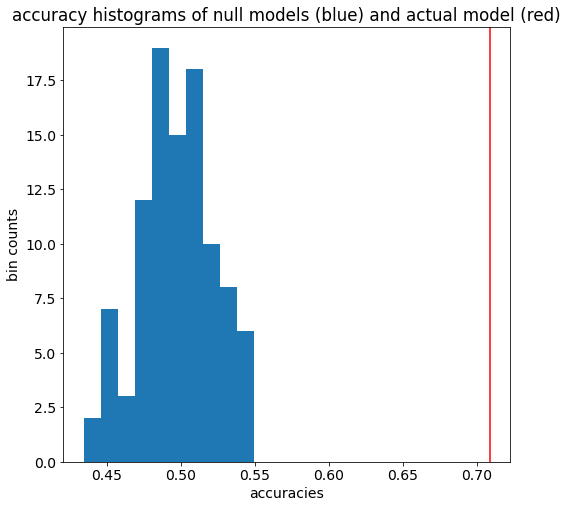

In [31]:
plt.hist(np.stack(null_eval_hists, axis=0))
plt.axvline(eval_hist[1], color='red')
plt.xlabel('accuracies')
plt.ylabel('bin counts')
plt.title('accuracy histograms of null models (blue) and actual model (red)')

## lesioning

In [32]:
vis = np.concatenate((np.arange(24),150+np.arange(24)))
somot = np.concatenate((np.arange(24,53),150+np.arange(24,53)))
dorsattn = np.concatenate((np.arange(53,69),150+np.arange(53,69)))
ventattn = np.concatenate((np.arange(69,85),150+np.arange(69,85)))
limbic = np.concatenate((np.arange(85,95),150+np.arange(85,95)))
cont = np.concatenate((np.arange(95,112),150+np.arange(95,112)))
default = np.concatenate((np.arange(112,150),150+np.arange(112,150)))
vvc = np.array([5,10,16,54,55,56,90,100,154,157,165,202,203,220,245,251,277,280]) -1
evea = np.array([16,165,10,157,5,154,25,174,26,178])-1
ev = np.array([16,165,10,157,5,154])-1
vis50 = np.array([162, 13, 157, 174, 11, 20, 169, 4, 156, 160, 167, 153, 19, 8, 5, 18, 6, 163, 159, 14, 24, 9, 10, 152, 22, 16, 172, 3, 155, 154])-1
def50 = np.array([119, 116, 126, 115, 281, 285, 273, 296, 147])-1
dA=np.array([124, 126, 129, 131, 137, 140, 144, 146, 148, 149, 150, 272, 274, 277, 285, 287, 288, 289, 290, 293, 297, 298, 299])-1
dB=np.array([93, 101, 113, 117, 118, 121, 123, 125, 127, 130, 132, 133, 135, 136, 138, 139, 141, 142, 276, 280, 282, 283, 284, 291, 294])-1
dC=np.array([2, 7, 94, 122, 143, 145, 152, 273, 295, 296])-1
dD=np.array([73, 115, 116, 119, 120, 175, 179, 220, 271, 278, 279, 281])-1
defA = np.array([i for i in dA if i in default])
defB = np.array([i for i in dB if i in default])
defC = np.array([i for i in dC if i in default])
defD = np.array([i for i in dD if i in default])
defE = np.array([i for i in default if i not in np.concatenate([defA,defB,defC,defD])])
limbicA = np.array([89, 90, 91, 92, 95, 242, 243, 244, 245, 246, 247])-1
limbicB = np.array([86, 87, 88, 128, 238, 239, 240, 241, 286])-1
VisCent_ExStr_7 = np.array([3, 5, 6, 8, 11, 13, 15, 18, 19, 22, 151, 153, 154, 156, 159, 160, 164, 167, 168, 171])-1
VisCent_Striate_7 = np.array([14, 163])-1
VisPeri_ExStrInf_7 = np.array([4, 9, 10, 12, 155, 157, 158, 161])-1
VisPeri_StriCal_7 = np.array([16, 165, 166])-1
VisPeri_ExStrSup_7 = np.array([17, 20, 21, 23, 169, 170, 173])-1
SomMotA_7 = np.array([38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201])-1
SomMotB_7 = np.array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 174, 176, 177, 178, 180, 181, 182, 183, 185])-1
SomMotB_Aud_7 = np.array([25, 26, 30, 174, 178])-1
SomMotB_S2_7 = np.array([27, 28, 29, 31, 32, 33, 176, 177, 180, 181, 182])-1
SomMotB_Cent_7 = np.array([34, 36, 37, 183, 185])-1

visual_remaining_after17 = np.array([i for i in vis if i not in np.concatenate([VisCent_ExStr_7, VisCent_Striate_7, VisPeri_ExStrInf_7, VisPeri_StriCal_7, VisPeri_ExStrSup_7])])
sommot_remaining_after17 = np.array([i for i in somot if i not in np.concatenate([SomMotA_7, SomMotB_7])])

masks_list = {
    'no lesion':None,
    'visual':vis,
    'somato-motor':somot,
    'dorsal attention':dorsattn,
    'ventral attention':ventattn,
    'limbic':limbic, 
    'executive control':cont, 
    'default mode':default, 
    'early-visual,auditory':evea,
    'early-visual':ev,
    'ventral visual cortex':vvc,
    'vis top50':vis50,
    'default top50':def50,
    'default A':defA,
    'default B':defB,
    'default C':defC,
    'temporal parietal':defD,
    'temporal parietal1':[118, 115, 114, 280, 119, 278],#, 277, 270]
    'remaining':defE,
    'limbic A':limbicA, 
    'limbic B':limbicB,
    'VisCent_ExStr_7':VisCent_ExStr_7,
    'VisCent_Striate_7':VisCent_Striate_7,
    'VisPeri_ExStrInf_7':VisPeri_ExStrInf_7,
    'VisPeri_StriCal_7':VisPeri_StriCal_7,
    'VisPeri_ExStrSup_7':VisPeri_ExStrSup_7,
    'SomMotA_7':SomMotA_7,
    'SomMotB_7':SomMotB_7,
    'SomMotB_Aud':SomMotB_Aud_7,
    'SomMotB_S2':SomMotB_S2_7,
    'SomMotB_Cent':SomMotB_Cent_7,
    'Visual remaining': visual_remaining_after17,
    'Sommot remaining': sommot_remaining_after17,
}

### lesioning individual networks
The 300 ROIs are divided into 7 networks

In [33]:
def length(x):
    if x is not None:
        return len(x)
    else:
        return 0
    
def mask_data(X, idx):
    X_abl = X.copy()
    if idx is not None:
        X_abl[:, :, idx] = 0.0
    return X_abl

records_file = f"{results_dir}/emoprox_full_data/lesion/records_hemolag{hemo_lag}.pkl"
if not os.path.exists(records_file):
    records = pd.DataFrame(data=None, columns=['network', 'idx_rois', 'num_rois', 'accuracy'])
    for idx_nw, (nw_name, idx_rois) in tqdm(enumerate(masks_list.items())): 
        # fill in the dataframe
        X_abl = mask_data(X_test, idx_rois)
        records.loc[idx_nw] = [nw_name, 
                                idx_rois, 
                                length(idx_rois), 
                                model.evaluate(X_abl, y_test, verbose=0)[1]]

    # save the dataframe
    records.to_pickle(records_file)

else:
    records = pd.read_pickle(records_file)

In [34]:
records

,network,idx_rois,num_rois,accuracy
0,no lesion,None,0,0.708579
1,visual,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",48,0.615333
2,somato-motor,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",58,0.701973
3,dorsal attention,"[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6...",32,0.701539
4,ventral attention,"[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8...",32,0.698416
5,limbic,"[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 235, ...",20,0.710561
6,executive control,"[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ...",34,0.707579
7,default mode,"[112, 113, 114, 115, 116, 117, 118, 119, 120, ...",76,0.705710
8,"early-visual,auditory","[15, 164, 9, 156, 4, 153, 24, 173, 25, 177]",10,0.699746
9,early-visual,"[15, 164, 9, 156, 4, 153]",6,0.699123


**The table above tells that an individual network or its subnetwork is reducing performance only upto second decimal point.** 
Hence, below we lesion combinations of networks to observe higher changes in accuracy.

### combinations of networks

In [35]:
nw_combs = {}
nw_combs[0] = []
nw_combs[1] = ['vis', 'somot', 'dorsattn', 'ventattn', 'limbic', 'cont', 'default']
for r in np.arange(2, 8):
    nw_combs[r] = list(combinations(nw_combs[1], r))

masks_list_nws = {
    'vis':vis,
    'somot':somot,
    'dorsattn':dorsattn,
    'ventattn':ventattn,
    'limbic':limbic, 
    'cont':cont, 
    'default':default}
    
def get_idx_rois(nw_names):
    idx_rois = []
    if type(nw_names) == tuple or type(nw_names)==list:
        for nw_name in nw_names:
            idx_rois += list(masks_list_nws[nw_name])
    else:
        idx_rois = list(masks_list_nws[nw_names])
    return idx_rois

def perform_lesioning(records_nw_combs_file, method='remove'):
    '''
    if r is in (1, 2, 3), we mask those sets of networks
    if r is in (4, 5, 6), we mask the remaining sets of networks
    '''
    if not os.path.exists(records_nw_combs_file):
        # create the df
        records_nw_combs = pd.DataFrame(data=None, columns=['network', 'idx_rois', 'num_rois', 'accuracy'])

        r_range = np.arange(1, 4) if method=='remove' else np.arange(4, 7)
        for r in r_range:
            for nw_names in tqdm(nw_combs[r]):
                # fill in the dataframe
                idx_rois = get_idx_rois(nw_names)
                X_abl = mask_data(X_test, idx_rois)
                d_ = {
                    'network':[nw_names if method=='remove' else tuple(set(nw_combs[1]) - set(nw_names))], 
                    'idx_rois':[idx_rois], 
                    'num_rois':[length(idx_rois)], 
                    'accuracy':[model.evaluate(X_abl, y_test, verbose=0)[1]]}
                records_nw_combs = pd.concat([records_nw_combs, pd.DataFrame(d_)]) 

            # save the dataframe
            records_nw_combs.to_pickle(records_nw_combs_file)

    else:
        records_nw_combs = pd.read_pickle(records_nw_combs_file)

    return records_nw_combs

records_nw_combs_remove_file = f"{results_dir}/emoprox_full_data/lesion/records_nw_combinations_remove_hemolag{hemo_lag}.pkl"
records_nw_combs_keep_file = f"{results_dir}/emoprox_full_data/lesion/records_nw_combinations_keep_hemolag{hemo_lag}.pkl"

records_nw_combs_remove = perform_lesioning(records_nw_combs_remove_file, method='remove')
records_nw_combs_keep = perform_lesioning(records_nw_combs_keep_file, method='keep')

In [36]:
def plot_lesion_bars(df, r, method='remove'):
    num_nws = len(df)

    cm = 1 #1/2.54
    nrows, ncols = 1, 1
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*cm, 0.5*num_nws*cm), 
        sharex=False,
        sharey=False,
        dpi=75)

    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    ax = axs

    if method=='remove':
        title = f"lesioning {r} networks together"
        cmap = 'Greens_r'
    elif method=='keep':
        title = f"keeping {r} networks"
        cmap = 'Greens'
    ax.set_title(title)

    x_pts = list(df['accuracy'].values)
    ax.barh(
        y=np.arange(num_nws, 0, -1),
        width=x_pts, 
        height=0.75, 
        color=mpl.colormaps[cmap](rescale(x_pts)))


    ax.axvline(
        x=records.iloc[0]['accuracy'], # original accuracy of the model
        color='orange', 
        linewidth=3.0)

    # layout
    ax.set_yticks(np.arange(num_nws, 0, -1))
    ax.set_yticklabels(df['network'].values)
    ax.set_xlim(0.5, 1.0)
    ax.grid(True)

    ax.set_xlabel(f"accuracy")
    ax.set_ylabel(f"networks")
    # ax.legend()
    
    return fig, axs

def tuple_length(x):
    if type(x) == tuple or type(x) == list:
        return len(x)
    elif type(x) == str:
        return 1

#### removing combinations of networks
Here we mask a set of networks and keep the remaining time series intact. This will tell us the drop in performance when we remove a set of networks.

As we want the maximum drop in performance, we sort the sets in ascending order.

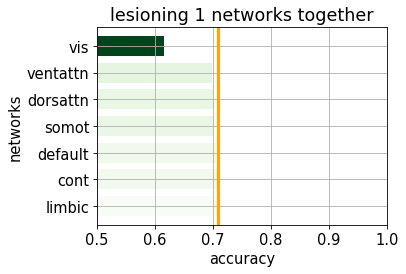

In [37]:
r = 1
df = records_nw_combs_remove[records_nw_combs_remove['network'].apply(tuple_length) == r]
df = df.sort_values(by=['accuracy'])
fig, ax = plot_lesion_bars(df, r, 'remove')

Accuracy drops by removing `Visual` network, so we consider it as important.

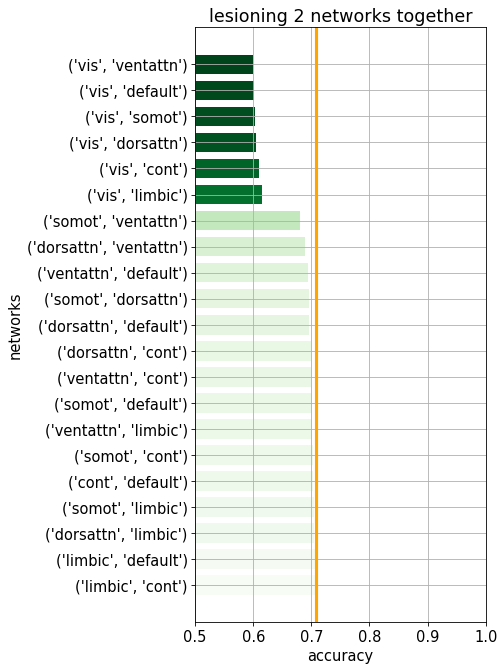

In [38]:
r = 2
df = records_nw_combs_remove[records_nw_combs_remove['network'].apply(tuple_length) == r]
df = df.sort_values(by=['accuracy'])
fig, ax = plot_lesion_bars(df, r, 'remove')

Removing `Visual`, and `Ventral attention` drops accuracy the most. Then `Visual` with `Default`.

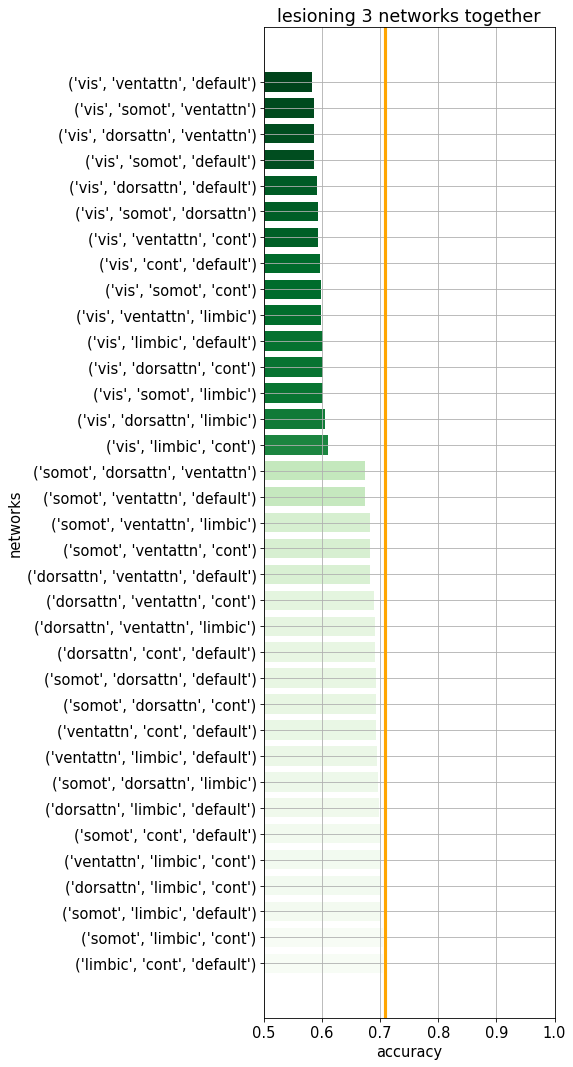

In [39]:
r = 3
df = records_nw_combs_remove[records_nw_combs_remove['network'].apply(tuple_length) == r]
df = df.sort_values(by=['accuracy'])
fig, ax = plot_lesion_bars(df, r, 'remove')

`Visual`, `Ventral attention`, and `Default` can be considered important.

#### keeping combinations of networks
Here we keep time series of a set of networks intact, and mask the remaining networks. This will tell us the *marginal* performance of the particular set of networks.

Since we keep only a set of networks, we see which set increases the performance. Hence the sets are sorted in descending order.

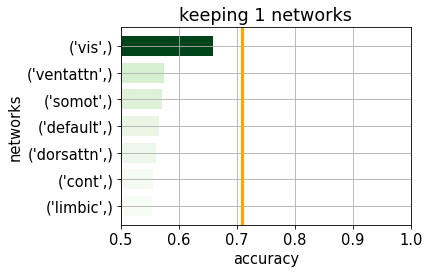

In [40]:
r = 1 # => 7 - 1 = 6 nws removed
df = records_nw_combs_keep[records_nw_combs_keep['network'].apply(tuple_length) == r]
df = df.sort_values(by=['accuracy'], ascending=False)
fig, ax = plot_lesion_bars(df, r, 'keep')

Again `Visual`

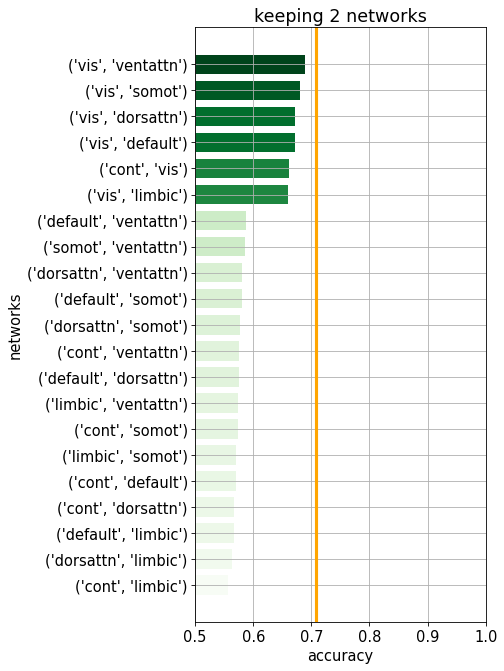

In [41]:
r = 2 # => 7 - 2 = 5 nws removed
df = records_nw_combs_keep[records_nw_combs_keep['network'].apply(tuple_length) == r]
df = df.sort_values(by=['accuracy'], ascending=False)
fig, ax = plot_lesion_bars(df, r, 'keep')

Now `Visual`, and `Ventral attention`.

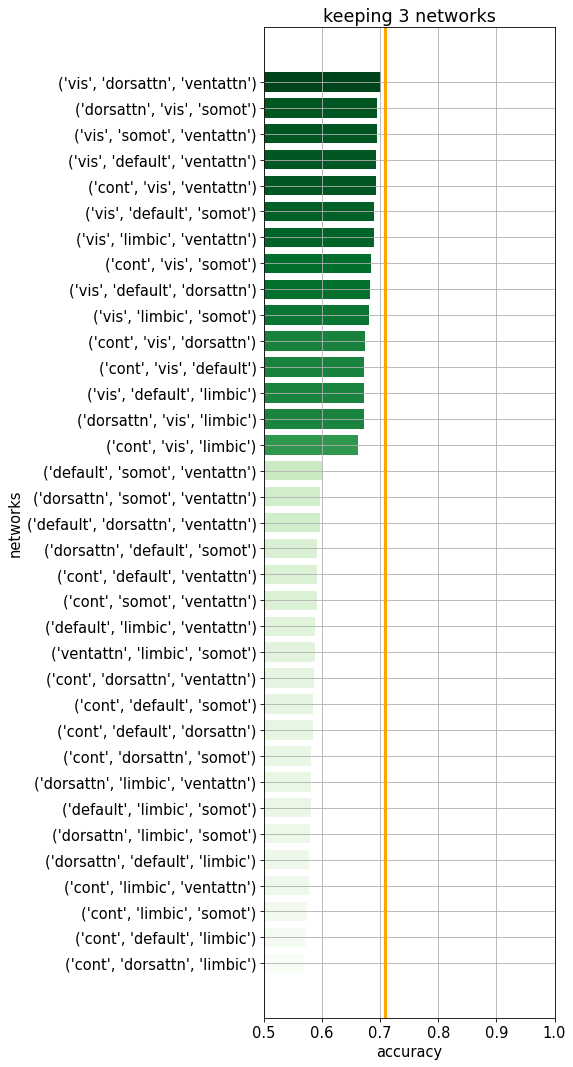

In [42]:
r = 3 # => 7 - 3 = 4 nws removed
df = records_nw_combs_keep[records_nw_combs_keep['network'].apply(tuple_length) == r]
df = df.sort_values(by=['accuracy'], ascending=False)
fig, ax = plot_lesion_bars(df, r, 'keep')

The same set of networks: `Visual`, `Ventral attention`, and `Dorsal attention`!!